In [1]:
import sys
print(sys.version)

import pandas as pd
import numpy as np

import geopandas as gpd
print(f'GeoPandas version:', gpd.__version__)

from shapely.geometry import Point, Polygon # gpd uses this for geometries
import pyproj # gpd uses pyproj for projections
import descartes #gpd using descartes to build areas with polygons

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns 


3.7.7 (default, Mar 23 2020, 17:31:31) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
GeoPandas version: 0.8.1


## Reading the taxi rides dataset to geopandas

The dataset that I'll be using for the mapping datapoint manipulation and analysis requires the dur_to_dist and neighbourhood wise assessment. So picking up the dataframe with additional columns of distance and price that's coming in from 1st jupyter notebook.

Creating separate sets for pickup and dropoff points.


In [2]:
df = pd.read_csv('./data/2_additional_col_set.csv')

In [3]:
df.head()


,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,duration_min,dur_to_dist,dur_to_dist_m,speed_kmph,speed_kmph_m,day_name,hour,price,month_name,day
0,0,id3487442,2,2016-02-29 18:39:00,2016-02-29 18:42:00,1,-73.981819,40.768963,-73.981819,40.768963,...,3.783333,inf,3.128858e-01,0.0,3.196055e+00,Monday,18,8.783333,February,29
1,1,id1145809,2,2016-05-16 23:15:00,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,...,15.783333,inf,1.305299e+00,0.0,7.661081e-01,Monday,23,22.861667,May,16
2,2,id3499387,1,2016-01-25 19:45:00,2016-01-25 19:54:00,1,-73.786720,40.647041,-73.786720,40.647041,...,9.666667,inf,7.994438e-01,0.0,1.250870e+00,Monday,19,14.666667,January,25
3,3,id0753277,1,2016-01-27 22:29:00,2016-01-27 22:29:00,1,-74.209854,40.816853,-74.209854,40.816853,...,0.450000,inf,2.616327e+09,0.0,3.822152e-10,Wednesday,22,5.450000,January,27
4,4,id2134482,1,2016-01-22 16:13:00,2016-01-22 16:13:00,1,-73.776314,40.645454,-73.776314,40.645454,...,0.316667,inf,2.200972e+09,0.0,4.543447e-10,Friday,16,5.316667,January,22


## Cleaning up the dataframe

In [4]:
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])

In [5]:
geometry_p = [Point(xy) for xy in zip(df['pickup_longitude'], df['pickup_latitude'])]
geometry_d = [Point(xy) for xy in zip(df['dropoff_longitude'], df['dropoff_latitude'])]
print(geometry_p[:3])
print(geometry_d[:3])

[<shapely.geometry.point.Point object at 0x7fd195261090>, <shapely.geometry.point.Point object at 0x7fd195261950>, <shapely.geometry.point.Point object at 0x7fd195261910>]
[<shapely.geometry.point.Point object at 0x7fd180a8b4d0>, <shapely.geometry.point.Point object at 0x7fd180a8b5d0>, <shapely.geometry.point.Point object at 0x7fd180a8b590>]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048468 entries, 0 to 1048467
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1048468 non-null  object 
 1   vendor_id           1048468 non-null  int64  
 2   pickup_datetime     1048468 non-null  object 
 3   dropoff_datetime    1048468 non-null  object 
 4   passenger_count     1048468 non-null  int64  
 5   pickup_longitude    1048468 non-null  float64
 6   pickup_latitude     1048468 non-null  float64
 7   dropoff_longitude   1048468 non-null  float64
 8   dropoff_latitude    1048468 non-null  float64
 9   store_and_fwd_flag  1048468 non-null  bool   
 10  duration            1048468 non-null  int64  
 11  distance            1048468 non-null  float64
 12  manhattan_dist      1048468 non-null  float64
 13  duration_hours      1048468 non-null  float64
 14  duration_min        1048468 non-null  float64
 15  dur_to_dist    

## Creating two geodf's for pickup and dropoff locations

In [7]:
crs ='epsg:4326'

In [8]:
#converting the dataframe to a geopandasdataframe for pickup points
geo_df_p = gpd.GeoDataFrame(df, crs = crs, geometry = geometry_p)
print(geo_df_p.head())

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id3487442          2  2016-02-29 18:39:00  2016-02-29 18:42:00   
1  id1145809          2  2016-05-16 23:15:00  2016-05-16 23:31:00   
2  id3499387          1  2016-01-25 19:45:00  2016-01-25 19:54:00   
3  id0753277          1  2016-01-27 22:29:00  2016-01-27 22:29:00   
4  id2134482          1  2016-01-22 16:13:00  2016-01-22 16:13:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.981819        40.768963         -73.981819   
1                6        -73.808487        40.687336         -73.808487   
2                1        -73.786720        40.647041         -73.786720   
3                1        -74.209854        40.816853         -74.209854   
4                1        -73.776314        40.645454         -73.776314   

   dropoff_latitude  store_and_fwd_flag  ...  dur_to_dist  dur_to_dist_m  \
0         40.768963               False  ...        

In [9]:
#converting the dataframe to a geopandasdataframe for dropoff points
geo_df_d = gpd.GeoDataFrame(df, crs = crs, geometry = geometry_d)
print(geo_df_d.head())

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id3487442          2  2016-02-29 18:39:00  2016-02-29 18:42:00   
1  id1145809          2  2016-05-16 23:15:00  2016-05-16 23:31:00   
2  id3499387          1  2016-01-25 19:45:00  2016-01-25 19:54:00   
3  id0753277          1  2016-01-27 22:29:00  2016-01-27 22:29:00   
4  id2134482          1  2016-01-22 16:13:00  2016-01-22 16:13:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.981819        40.768963         -73.981819   
1                6        -73.808487        40.687336         -73.808487   
2                1        -73.786720        40.647041         -73.786720   
3                1        -74.209854        40.816853         -74.209854   
4                1        -73.776314        40.645454         -73.776314   

   dropoff_latitude  store_and_fwd_flag  ...  dur_to_dist  dur_to_dist_m  \
0         40.768963               False  ...        

## Geoplotting the pincode map of NYC with geopandas

Reference link: https://geodata.lib.berkeley.edu/catalog/nyu-2451-34509

In [10]:
pincodes = gpd.read_file('./nyu-zipcode file/nyu_2451_34509.shp')

In [11]:
# getting a read on the data

print(pincodes.shape)
print(pincodes.head())
print(type(pincodes))

(214, 4)
    zcta  bcode  note                                           geometry
0  10001  36061  None  POLYGON ((-74.00368 40.74835, -74.00653 40.749...
1  10002  36061  None  POLYGON ((-73.99695 40.71207, -73.99712 40.712...
2  10003  36061  None  POLYGON ((-73.99206 40.72564, -73.99179 40.726...
3  10007  36061  None  POLYGON ((-74.01046 40.71153, -74.01015 40.712...
4  10009  36061  None  POLYGON ((-73.97521 40.71924, -73.97512 40.719...
<class 'geopandas.geodataframe.GeoDataFrame'>


We have **214 zipcodes** in the shapefile and this should help us plot out the stats for pickup and drop off points separately.

In [12]:
# verifying to check if the coordinate reference system corresponds to the lat long geometries
print(pincodes.crs)

epsg:4326


<AxesSubplot:>

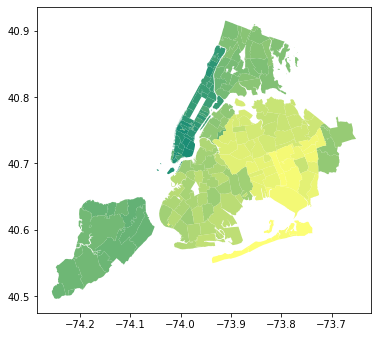

In [13]:
# plotting the pincode area map 

fig, ax = plt.subplots(figsize=(6,6), edgecolor='white',linewidth=3)
pincodes.plot(ax=ax,  alpha = 0.9, cmap='summer')


## Spatial join 

Next step, we will perform a spatial join first on `geo_df` the taxi-geo dataset to that of the `pincodes` geodataframe and map out the location of `pickup points` and `dropoff points` separately - based on the zipcodes and the boro-codes information.


### Spatial join - Pickup coordinates

In [14]:
joined_p = gpd.sjoin(geo_df_p, pincodes, how='left', op='within')

print(joined_p.head())

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id3487442          2  2016-02-29 18:39:00  2016-02-29 18:42:00   
1  id1145809          2  2016-05-16 23:15:00  2016-05-16 23:31:00   
2  id3499387          1  2016-01-25 19:45:00  2016-01-25 19:54:00   
3  id0753277          1  2016-01-27 22:29:00  2016-01-27 22:29:00   
4  id2134482          1  2016-01-22 16:13:00  2016-01-22 16:13:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.981819        40.768963         -73.981819   
1                6        -73.808487        40.687336         -73.808487   
2                1        -73.786720        40.647041         -73.786720   
3                1        -74.209854        40.816853         -74.209854   
4                1        -73.776314        40.645454         -73.776314   

   dropoff_latitude  store_and_fwd_flag  ...   day_name  hour      price  \
0         40.768963               False  ...     Mon

In this view note that there are some NaN values. Most likely they correspond 
to the 'points' that lie outside of the polygon geometries. 

Lets verify this and separate the dataset into 2 sets

1. Rows that fall **'within'** the boundaries. 
2. Rows that all **'outside'** the boundaries.


In [15]:
# picking the not null or `inliers` for further analysis

print(joined_p[joined_p.zcta.notnull()].shape)
joined_inliers_p = joined_p[joined_p.zcta.notnull()]

# picking the null dataset or `outliers `for further analysis.

print(joined_p[joined_p.zcta.isnull()].shape)
joined_outliers_p = joined_p[joined_p.zcta.isnull()]


(1032162, 29)
(16306, 29)


In [16]:
#saving the dataframe for further analysis later

joined_inliers_p.to_csv('./data/joined_inliers_p.csv')
joined_outliers_p.to_csv('./data/joined_outliers_p.csv')

**Approx ~ 16,300 pickup observations** fall outside of the NYC borough boundary region.


### Spatial join - Dropoff coordinates

In [17]:
joined_d = gpd.sjoin(geo_df_d, pincodes, how='left', op='within')
print(joined_d.head())
print()

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id3487442          2  2016-02-29 18:39:00  2016-02-29 18:42:00   
1  id1145809          2  2016-05-16 23:15:00  2016-05-16 23:31:00   
2  id3499387          1  2016-01-25 19:45:00  2016-01-25 19:54:00   
3  id0753277          1  2016-01-27 22:29:00  2016-01-27 22:29:00   
4  id2134482          1  2016-01-22 16:13:00  2016-01-22 16:13:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.981819        40.768963         -73.981819   
1                6        -73.808487        40.687336         -73.808487   
2                1        -73.786720        40.647041         -73.786720   
3                1        -74.209854        40.816853         -74.209854   
4                1        -73.776314        40.645454         -73.776314   

   dropoff_latitude  store_and_fwd_flag  ...   day_name  hour      price  \
0         40.768963               False  ...     Mon

In [18]:
# picking the not null or `inliers` for further analysis

print(joined_d[joined_d.zcta.notnull()].shape)
joined_inliers_d = joined_d[joined_d.zcta.notnull()]

# picking the null dataset or `outliers `for further analysis.

print(joined_d[joined_d.zcta.isnull()].shape)
joined_outliers_d = joined_d[joined_d.zcta.isnull()]


(1031036, 29)
(17432, 29)


**Approx ~ 17,500 drop off observations** fall outside of the NYC borough boundary region.

In this view note that there are some NaN values. Most likely they correspond 
to the 'points' that lie outside of the polygon geometries. 

Lets verify this and separate the dataset into 2 sets

1. Rows that fall **'within'** the boundaries. 
2. Rows that all **'outside'** the boundaries.


In [19]:
#saving the dataframe for further analysis later

joined_inliers_d.to_csv('./data/joined_inliers_d.csv')
joined_outliers_d.to_csv('./data/joined_outliers_d.csv')

## Geographical Mapping - Pickup Coordinates

Q1. Which neighborhoods/zip codes tends to experience a relatively higher density of pick-ups? 

Q3. Which neighborhoods/zip codes tends to have the highest duration-to-distance ratios, based on pick-up?

In [20]:
# gdf_p is the taxi rides dataset that upon merging with the pincodes (shp) file - gave the joined_p dataframe.
# Grouping the data by zipcode and rounding up the count of pickup's in each area helps us answer teh above q's

print(joined_p['zcta'].value_counts())  #202 unique count of areacodes
print(pincodes.info()) # 214 areas for pincode `zcta`

10019    67474
10022    56330
10003    54568
10016    54285
10011    53945
         ...  
10314        1
11411        1
11693        1
11692        1
10303        1
Name: zcta, Length: 202, dtype: int64
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zcta      214 non-null    object  
 1   bcode     214 non-null    object  
 2   note      5 non-null      object  
 3   geometry  214 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 6.8+ KB
None


In [22]:
# setting the index of pincodes to `zcta` 

pincodes.set_index('zcta',inplace=True)

In [23]:
pincodes['zcta_count_p'] = joined_p['zcta'].value_counts()

In [24]:
print(pincodes.shape)
print(pincodes.head())
print(pincodes.info())

(214, 4)
       bcode  note                                           geometry  \
zcta                                                                    
10001  36061  None  POLYGON ((-74.00368 40.74835, -74.00653 40.749...   
10002  36061  None  POLYGON ((-73.99695 40.71207, -73.99712 40.712...   
10003  36061  None  POLYGON ((-73.99206 40.72564, -73.99179 40.726...   
10007  36061  None  POLYGON ((-74.01046 40.71153, -74.01015 40.712...   
10009  36061  None  POLYGON ((-73.97521 40.71924, -73.97512 40.719...   

       zcta_count_p  
zcta                 
10001       52313.0  
10002       19528.0  
10003       54568.0  
10007        8237.0  
10009       19905.0  
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 214 entries, 10001 to 11697
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   bcode         214 non-null    object  
 1   note          5 non-null      object  
 2   geometry      214 non-null    g

Text(0.5, 1.0, 'Top 10 zip code with highest density pickups')

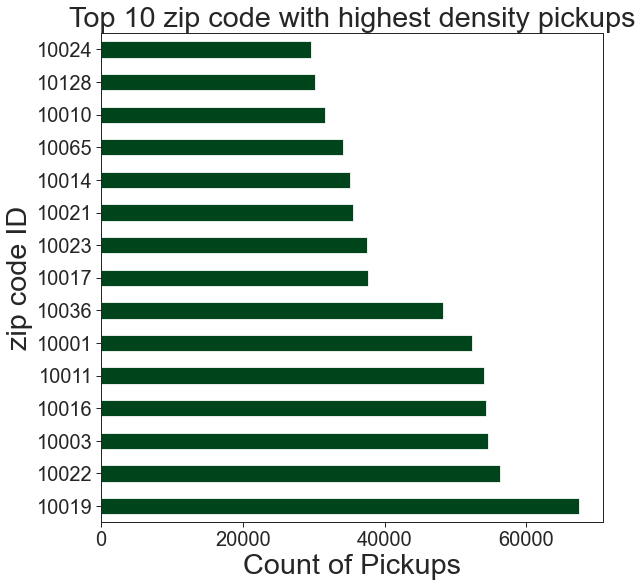

In [47]:
from matplotlib import style
#styles
# style.use('ggplot')
sns.set_theme(style="whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale = 3,)


# mapping top 10 zipcodes that have highest pickup numbers

fig,ax = plt.subplots(figsize=(9,9))
t15_p = joined_p['zcta'].value_counts().sort_values(ascending=False).head(15)
t15_p.plot.barh(ax=ax, fontsize=20,cmap='Greens_r')
ax.set_xlabel('Count of Pickups')
ax.set_ylabel('zip code ID')
ax.set_title('Top 10 zip code with highest density pickups')


<AxesSubplot:>

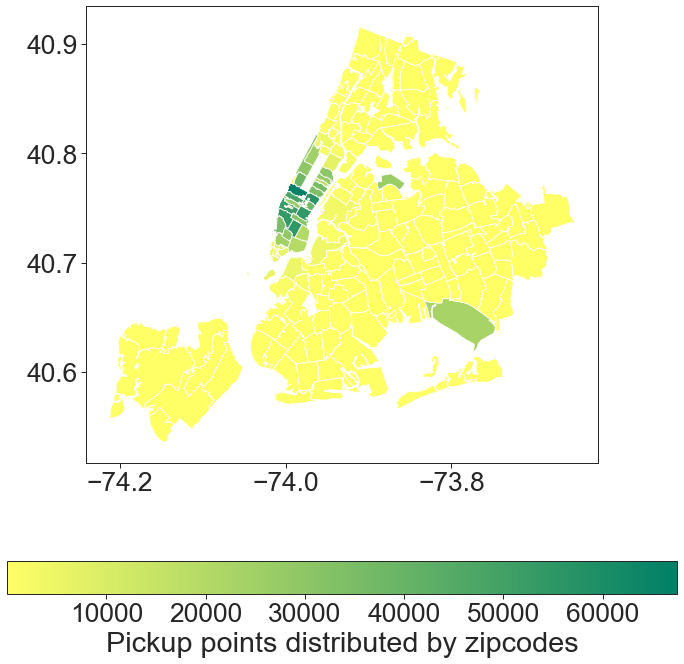

In [44]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(12,12), edgecolor='white',linewidth=4)
# sns.set_context("paper", font_scale = 1.1)
pincodes.plot(column='zcta_count_p', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "Pickup points distributed by zipcodes",'orientation':'horizontal'})

### Mapping Manhattan borough - Pickup

In [54]:
# quering the dataset by limiting the output to 'Manhattan' alone with borough code = 36061.

pincodes_manhattan = pincodes.query('bcode == "36061"').sort_values(by='zcta_count_p',ascending=False).head(12)


<AxesSubplot:>

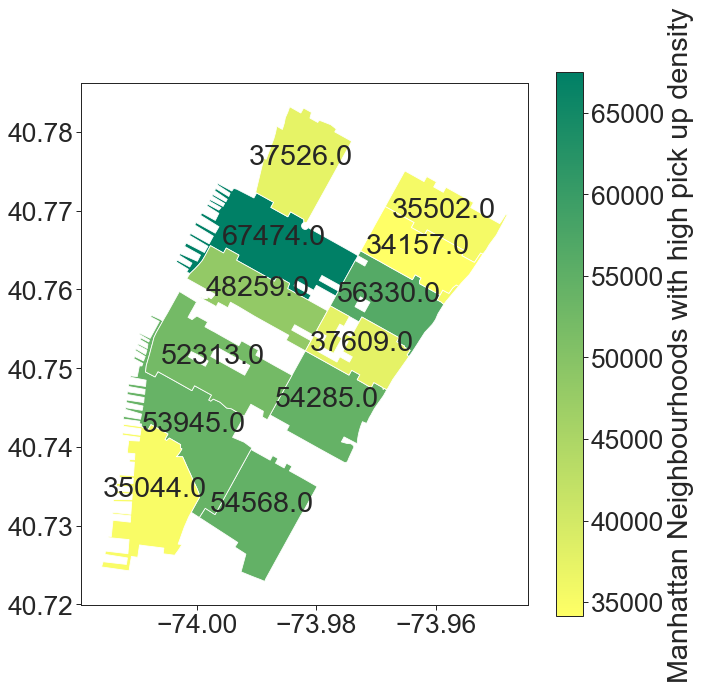

In [55]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(10,10), edgecolor='white',linewidth=4)

#label each zipcode with pickup count
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.zcta_count_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

pincodes_manhattan.plot(column='zcta_count_p', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "Manhattan Neighbourhoods with high pick up density"})



### Mapping dur_to_dist - Pickup


In [28]:
pincodes['dur_to_dist_mean_p'] = joined_p.groupby('zcta')['dur_to_dist'].agg('median')
print(pincodes.sample(3))

       bcode  note                                           geometry  \
zcta                                                                    
10162  36061  None  POLYGON ((-73.95140 40.77007, -73.94994 40.769...   
11414  36081  None  MULTIPOLYGON (((-73.85566 40.66380, -73.85606 ...   
10154  36061  None  POLYGON ((-73.97307 40.75843, -73.97145 40.757...   

       zcta_count_p  dur_to_dist_mean_p  
zcta                                     
10162         443.0            0.081992  
11414           6.0            0.047699  
10154         960.0            0.082184  


<AxesSubplot:>

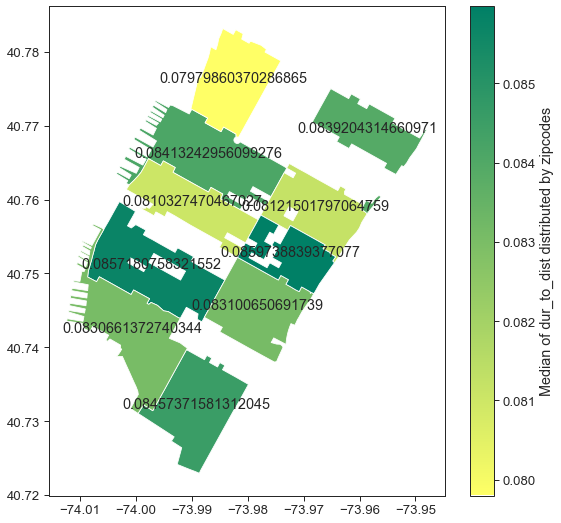

In [71]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=4)

#label each zipcode with dur_to_dist_p
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.dur_to_dist_mean_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)


pincodes_manhattan.plot(column='dur_to_dist_mean_p', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "Median of dur_to_dist distributed by zipcodes"})

## Geographical Mapping - Dropoff Coordinates

Q2. Which neighborhoods/zip codes tends to experience a relatively higher density of drop-offs?

Q4. Which neighborhoods/zip codes tends to have the highest duration-to-distance ratios, based on drop-off?

In [59]:
pincodes['zcta_count_d'] = joined_d['zcta'].value_counts()

In [60]:
print(pincodes.shape)
print(pincodes.head())
print(pincodes.info())

(214, 6)
       bcode  note                                           geometry  \
zcta                                                                    
10001  36061  None  POLYGON ((-74.00368 40.74835, -74.00653 40.749...   
10002  36061  None  POLYGON ((-73.99695 40.71207, -73.99712 40.712...   
10003  36061  None  POLYGON ((-73.99206 40.72564, -73.99179 40.726...   
10007  36061  None  POLYGON ((-74.01046 40.71153, -74.01015 40.712...   
10009  36061  None  POLYGON ((-73.97521 40.71924, -73.97512 40.719...   

       zcta_count_p  dur_to_dist_mean_p  zcta_count_d  
zcta                                                   
10001       52313.0            0.085718       52466.0  
10002       19528.0            0.073530       17993.0  
10003       54568.0            0.084574       45123.0  
10007        8237.0            0.073270        6813.0  
10009       19905.0            0.079960       19518.0  
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 214 entries, 10001 to 11697
Data c

Text(0.5, 1.0, 'Top 10 zip code with highest density drop-offs')

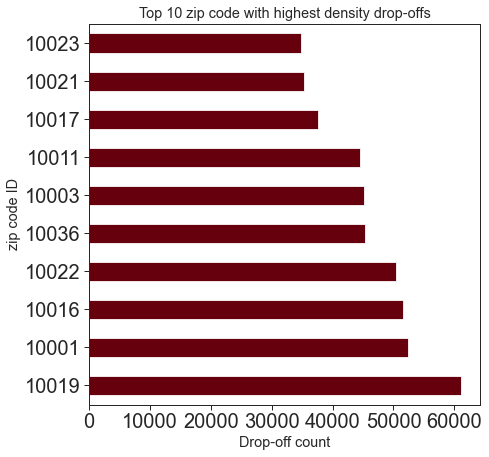

In [61]:
#styles
# style.use('ggplot')
sns.set_theme(style="whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.5,)

# mapping top 10 zipcodes that have highest density drop-offs

fig,ax = plt.subplots(figsize=(7, 7))
joined_d['zcta'].value_counts().sort_values(ascending=False).head(10).plot.barh(ax=ax, fontsize=20, cmap='Reds_r')
ax.set_xlabel('Drop-off count')
ax.set_ylabel('zip code ID')
ax.set_title('Top 10 zip code with highest density drop-offs')


<AxesSubplot:>

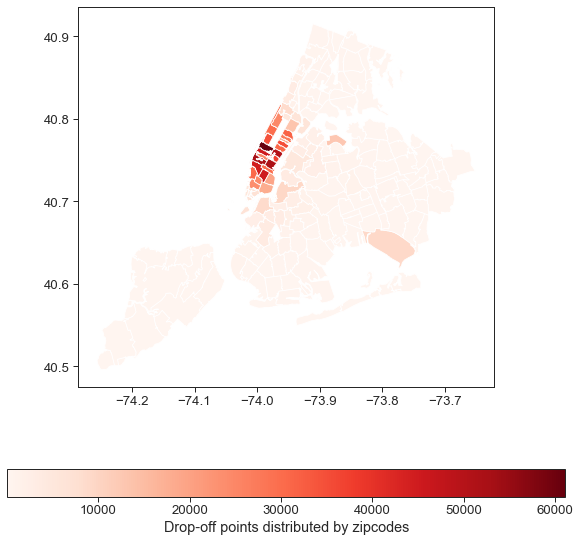

In [62]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(10,10), edgecolor='white',linewidth=4)
pincodes.plot(column='zcta_count_d', 
            ax=ax,
            cmap = 'Reds',  
            legend=True, 
            legend_kwds={'label': "Drop-off points distributed by zipcodes",'orientation':'horizontal'})

### Mapping Manhattan borough - Dropoff

In [63]:
# quering the dataset by limiting the output to 'Manhattan' alone with borough code = 36061.

pincodes_manhattan = pincodes.query('bcode == "36061"').sort_values(by='zcta_count_d',ascending=False).head(10)


<AxesSubplot:>

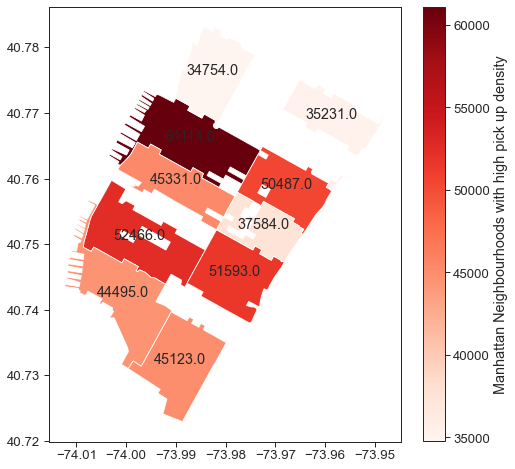

In [64]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(8,8), edgecolor='white',linewidth=2)

#label each zipcode
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.zcta_count_d, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

pincodes_manhattan.plot(column='zcta_count_d', 
            ax=ax,
            cmap = 'Reds',  
            legend=True, 
            legend_kwds={'label': "Manhattan Neighbourhoods with high pick up density"})



In [65]:
# quering the dataset by limiting the output to 'Manhattan' alone with borough code = 36061.

pincodes.query('bcode == "36061"').sort_values(by='zcta_count_d',ascending=False).head(10)

,bcode,note,geometry,zcta_count_p,dur_to_dist_mean_p,zcta_count_d
zcta,,,,,,
10019,36061,None,"POLYGON ((-73.99270 40.76343, -73.99336 40.763...",67474.0,0.084132,61114.0
10001,36061,None,"POLYGON ((-74.00368 40.74835, -74.00653 40.749...",52313.0,0.085718,52466.0
10016,36061,None,"POLYGON ((-73.98362 40.74972, -73.98317 40.750...",54285.0,0.083101,51593.0
10022,36061,None,"POLYGON ((-73.96934 40.76355, -73.96773 40.762...",56330.0,0.081215,50487.0
10036,36061,None,"POLYGON ((-73.99819 40.76492, -73.99774 40.765...",48259.0,0.081033,45331.0
10003,36061,None,"POLYGON ((-73.99206 40.72564, -73.99179 40.726...",54568.0,0.084574,45123.0
10011,36061,None,"POLYGON ((-74.00368 40.74835, -74.00351 40.748...",53945.0,0.083066,44495.0
10017,36061,None,"POLYGON ((-73.96856 40.74743, -73.96878 40.747...",37609.0,0.085974,37584.0
10021,36061,None,"MULTIPOLYGON (((-73.95102 40.76567, -73.95153 ...",35502.0,0.083920,35231.0


Text(0.5, 1.0, 'Top 10 zip code with highest density drop-offs on Manhattan')

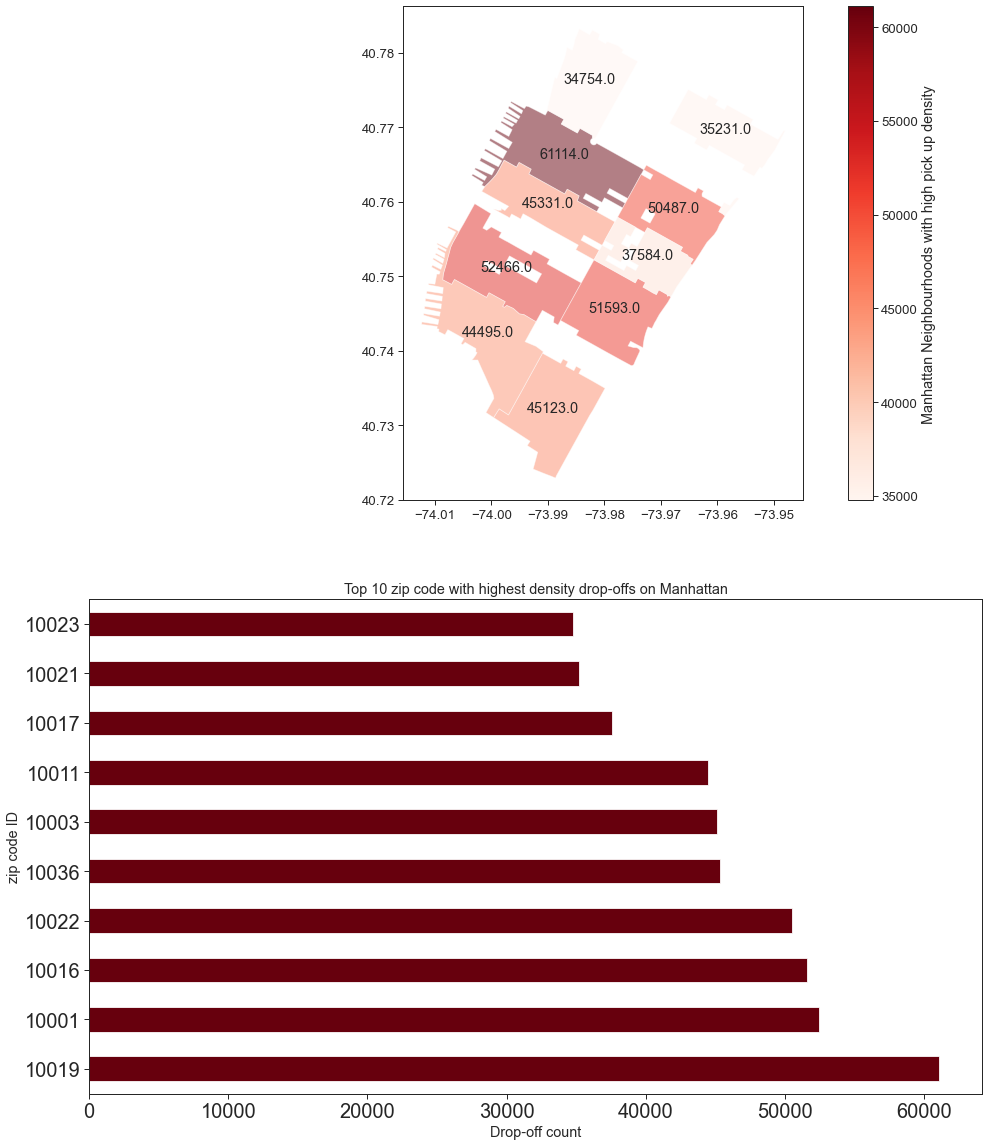

In [66]:
## plotting in subplots. 

fig = plt.figure(figsize=(16,20))

ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

#label each zipcode
pincodes_manhattan.apply(lambda x: ax1.annotate(text=x.zcta_count_d, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

pincodes_manhattan.plot(column='zcta_count_d', 
            ax=ax1,
            alpha=0.5,
            cmap = 'Reds', 
            legend=True, 
            legend_kwds={'label': "Manhattan Neighbourhoods with high pick up density"})


# mapping top 10 zipcodes that have highest density drop-offs

joined_d['zcta'].value_counts().sort_values(ascending=False).head(10).plot.barh(ax=ax2, fontsize=20, cmap='Reds_r')
ax2.set_xlabel('Drop-off count')
ax2.set_ylabel('zip code ID')
ax2.set_title('Top 10 zip code with highest density drop-offs on Manhattan')



### Mapping dur_to_dist - Dropoff


In [67]:
pincodes['dur_to_dist_mean_d'] = joined_d.groupby('zcta')['dur_to_dist'].agg('median')
print(pincodes.sample(3))

       bcode  note                                           geometry  \
zcta                                                                    
10303  36085  None  POLYGON ((-74.18794 40.62925, -74.18805 40.629...   
11208  36047  None  POLYGON ((-73.87671 40.65871, -73.87773 40.660...   
11417  36081  None  POLYGON ((-73.86203 40.67789, -73.86235 40.679...   

       zcta_count_p  dur_to_dist_mean_p  zcta_count_d  dur_to_dist_mean_d  
zcta                                                                       
10303           1.0                 inf           9.0            0.039401  
11208          20.0            0.062788         216.0            0.049277  
11417          11.0            0.041430         117.0            0.045282  


KeyError: 'dur_to_dist_mean_d'

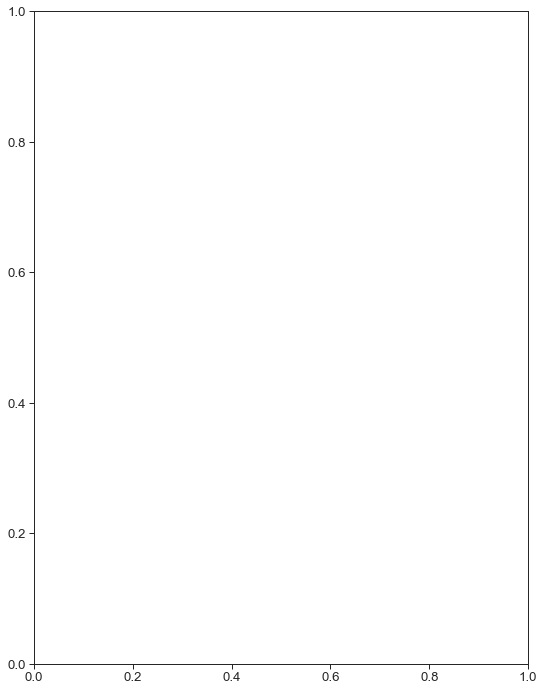

In [70]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(12,12), edgecolor='white',linewidth=4)

#label each zipcode with dur_to_dist_p
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.dur_to_dist_mean_d, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)


pincodes_manhattan.plot(column='dur_to_dist_mean_d', 
            ax=ax,
            cmap = 'Reds',  
            legend=True, 
            legend_kwds={'label': "Median of dur_to_dist distributed by zipcodes"})

Q5. For any of the neighborhoods identified, are there any potential areas within the neighborhood that are optimal for flying taxi pick-up / drop-off? What makes them suitable?